In [1]:
from scipy.io.wavfile import read, write
import torchaudio
import torch
from librosa.util import normalize
from librosa.filters import mel as librosa_mel_fn
import numpy as np
import librosa
import librosa.display
from tqdm import tqdm
import os
import soundfile as sf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
MAX_WAV_VALUE = 32768.0

def load_wav(full_path):
    sampling_rate, data = read(full_path)
    return data, sampling_rate

def dynamic_range_compression(x, C=1, clip_val=1e-5):
    return np.log(np.clip(x, a_min=clip_val, a_max=None) * C)

def dynamic_range_decompression(x, C=1):
    return np.exp(x) / C

def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)

def dynamic_range_decompression_torch(x, C=1):
    return torch.exp(x) / C

def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output

def spectral_de_normalize_torch(magnitudes):
    output = dynamic_range_decompression_torch(magnitudes)
    return output

mel_basis = {}
hann_window = {}

def mel_spectrogram(y, n_fft, num_mels, sampling_rate, hop_size, win_size, fmin, fmax, center=False):
    if torch.min(y) < -1.:
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel = librosa_mel_fn(sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax)
        mel_basis[str(fmax)+'_'+str(y.device)] = torch.from_numpy(mel).float().to(y.device)
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)

    y = torch.nn.functional.pad(y.unsqueeze(1), (int((n_fft-hop_size)/2), int((n_fft-hop_size)/2)), mode='reflect')
    y = y.squeeze(1)

    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True)

    spec = torch.sqrt(spec.pow(2).sum(-1)+(1e-9))

    spec = torch.matmul(mel_basis[str(fmax)+'_'+str(y.device)], spec)
    spec = spectral_normalize_torch(spec)

    return spec

In [9]:
ac_wav_path = "/blob/v-yuancwang/audio_editing_data/audiocaps/wav"
save_path = "/blob/v-yuancwang/audio_editing_data/sr"
wav_files = os.listdir(ac_wav_path)

In [40]:
for file_name in tqdm(wav_files[:]):
    wav, sr = librosa.load(os.path.join(ac_wav_path, file_name), sr=8000)
    wav = wav * MAX_WAV_VALUE
    wav = wav.astype('int16')
    write(os.path.join(save_path, "wav", file_name), 8000, wav)

for file_name in tqdm(wav_files[:]):
    wav, sr = librosa.load(os.path.join(save_path, "wav", file_name), sr=16000)
    x = torch.FloatTensor(wav)
    # print(len(x))
    x = mel_spectrogram(x.unsqueeze(0), n_fft=1024, num_mels=80, sampling_rate=16000,
                    hop_size=256, win_size=1024, fmin=0, fmax=8000)
    # print(x.shape)
    spec = x.cpu().numpy()[0]
    # print(spec.shape)
    wav = wav * MAX_WAV_VALUE
    wav = wav.astype('int16')
    write(os.path.join(save_path, "wav", file_name), 16000, wav)
    np.save(os.path.join(save_path, "mel", file_name.replace(".wav", ".npy")), spec)    

  0%|          | 0/10 [00:00<?, ?it/s]

(80, 624)


 10%|█         | 1/10 [00:01<00:09,  1.09s/it]

(80, 624)


 20%|██        | 2/10 [00:01<00:07,  1.06it/s]

(80, 624)


 30%|███       | 3/10 [00:02<00:06,  1.00it/s]

(80, 624)


 40%|████      | 4/10 [00:03<00:05,  1.10it/s]

(80, 624)


 50%|█████     | 5/10 [00:04<00:04,  1.12it/s]

(80, 624)


 60%|██████    | 6/10 [00:05<00:03,  1.24it/s]

(80, 624)


 70%|███████   | 7/10 [00:05<00:02,  1.33it/s]

(80, 624)


 80%|████████  | 8/10 [00:06<00:01,  1.34it/s]

(80, 624)


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]

(80, 624)


AudioMetaData(sample_rate=16000, num_frames=159872, num_channels=1, bits_per_sample=16, encoding=PCM_S)
(80, 624)


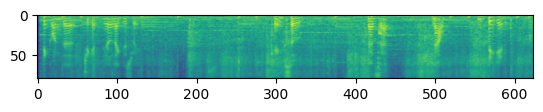

In [33]:
metadata0 = torchaudio.info(os.path.join(ac_wav_path, wav_files[1]))
print(metadata0)
wav0, sr0 = librosa.load(os.path.join(ac_wav_path, wav_files[1]), sr=16000)
x0 = torch.FloatTensor(wav0)
x0 = mel_spectrogram(x0.unsqueeze(0), n_fft=1024, num_mels=80, sampling_rate=16000,
    hop_size=256, win_size=1024, fmin=0, fmax=8000)
spec0 = x0.cpu().numpy()[0]
print(spec0.shape)
plt.imshow(spec0)

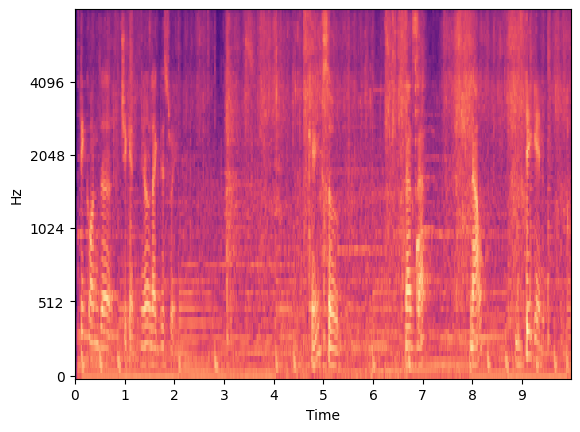

In [37]:
librosa.display.specshow(spec0, sr=16000, hop_length=256, x_axis='time', y_axis='mel')
plt.show()

AudioMetaData(sample_rate=8000, num_frames=79936, num_channels=1, bits_per_sample=16, encoding=PCM_S)
(80, 624)


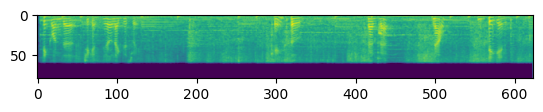

In [38]:
metadata1 = torchaudio.info(os.path.join(save_path, "wav", wav_files[1]))
print(metadata1)
wav1, sr1 = librosa.load(os.path.join(save_path, "wav", wav_files[1]), sr=16000)
x1 = torch.FloatTensor(wav1)
x1 = mel_spectrogram(x1.unsqueeze(0), n_fft=1024, num_mels=80, sampling_rate=16000,
    hop_size=256, win_size=1024, fmin=0, fmax=8000)
spec1 = x1.cpu().numpy()[0]
print(spec1.shape)
plt.imshow(spec1)

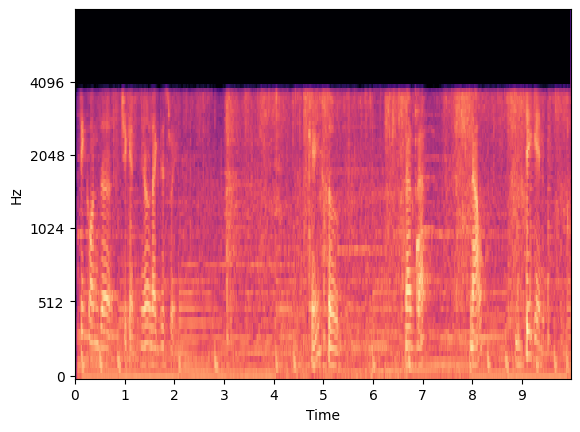

In [39]:
librosa.display.specshow(spec1, sr=16000, hop_length=256, x_axis='time', y_axis='mel')
plt.show()